**Kaggle link**

[Dataset on kaggle](https://www.kaggle.com/loveall/appliances-energy-prediction)

**Context**

Experimental data used to create regression models of appliances energy use in a low energy building.

**Content**

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

**T dew point**

If you are interested in a calculation that gives an approximation of dew point temperature if you know the observed temperature and relative humidity, the following formula was proposed in a 2005 article by Mark G. Lawrence in the Bulletin of the American Meteorological Society:

Td = T - ((100 - RH)/5.)

where Td is dew point temperature (in degrees Celsius), T is observed temperature (in degrees Celsius), and RH is relative humidity (in percent). Apparently this relationship is fairly accurate for relative humidity values above 50%.

# Import and Load data

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from datetime import datetime
from enum import Enum
from itertools import combinations, product

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

FIGURE_SIZE = (15, 12)
SNS_FIGURE_SIZE = (20, 15)
RANDOM_STATE = 42
TEST_SIZE = 0.2

file_path = '/content/KAG_energydata_complete.csv'
loaded_df = pd.read_csv(file_path, parse_dates=['date'])

features_df = loaded_df.drop(['rv1', 'rv2','lights', 'Appliances'], axis = 1)
target_column = loaded_df['Appliances'] + loaded_df['lights'] # Both represent energy use in Wh

# View data

First lets take a look at the shape of our dataframe, to see how many potential features we have and the size of our infomation (observations)

In [2]:
features_df.shape

(19735, 25)

So we have 19735 row, meaning that we have enough information for our regression

But we have 25 potential features! that could easily cause our model to be overfitted - we'll have to reduce this number

### Missing values

Lets check for missing values in our dataframe

In [3]:
loaded_df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

No missing values!

### Correlation map

Next we'll check for correlation between our features, as our current goal is reduce the number of features

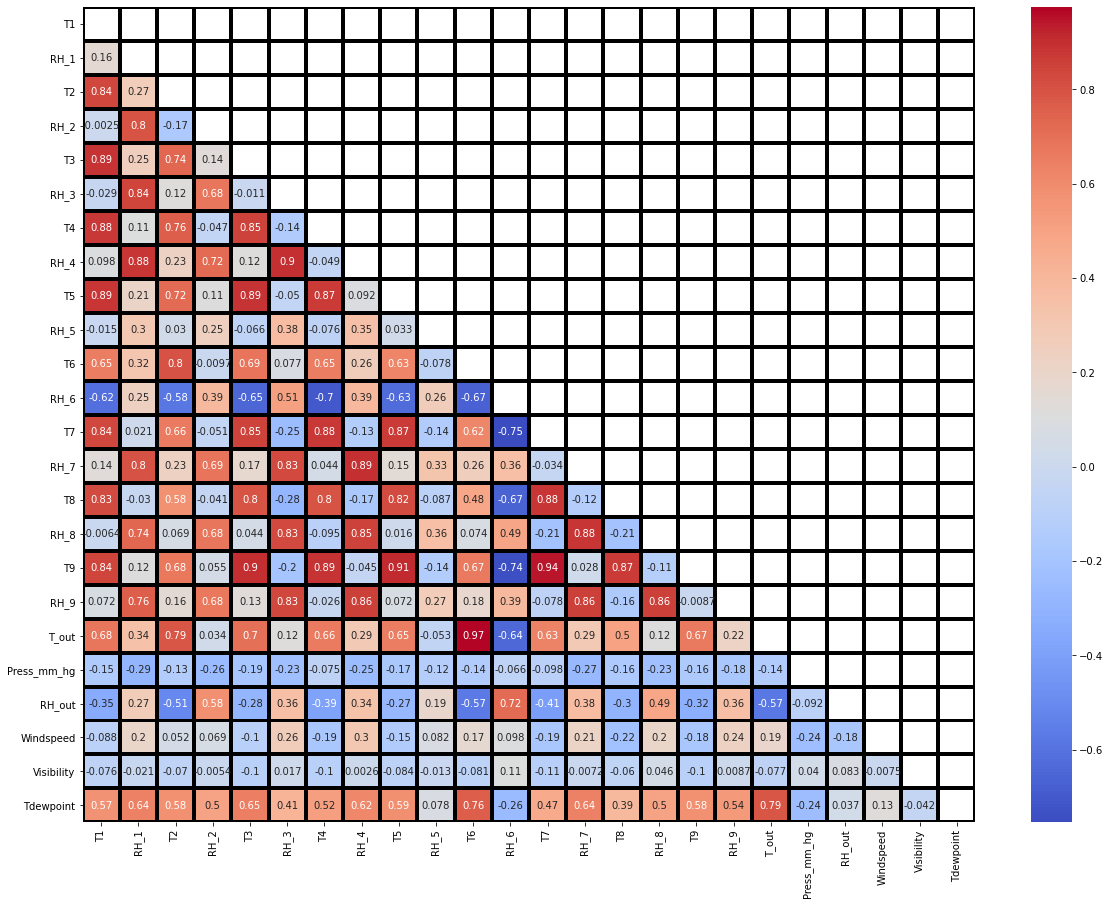

In [4]:
fig, ax = plt.subplots(figsize=SNS_FIGURE_SIZE)
mask_matrix = np.triu(features_df.corr())
sns.heatmap(features_df.corr(), annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', mask=mask_matrix)

If we set the "correlation limit" to 0.8, we get 4 potential groups of variables with high correlation and therefore redundent

In [100]:
correlated_column_group_1 = ['T1', 'T2', 'T3', 'T4', 'T5', 'T7', 'T8', 'T9']
correlated_column_group_2 = ['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_7']
correlated_column_group_3 = ['T6', 'T_out'] # Tdewpoint could be added (correlation of 0.79)
correlated_column_group_4 = ['RH_8', 'RH_9']

### More viewing options

In [6]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   T1           19735 non-null  float64       
 2   RH_1         19735 non-null  float64       
 3   T2           19735 non-null  float64       
 4   RH_2         19735 non-null  float64       
 5   T3           19735 non-null  float64       
 6   RH_3         19735 non-null  float64       
 7   T4           19735 non-null  float64       
 8   RH_4         19735 non-null  float64       
 9   T5           19735 non-null  float64       
 10  RH_5         19735 non-null  float64       
 11  T6           19735 non-null  float64       
 12  RH_6         19735 non-null  float64       
 13  T7           19735 non-null  float64       
 14  RH_7         19735 non-null  float64       
 15  T8           19735 non-null  float64       
 16  RH_8

In [7]:
features_df.describe()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707
std,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648
min,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000
25%,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000
50%,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333
75%,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667
max,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000


In [8]:
features_df.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,2016-01-11 17:00:00,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,2016-01-11 17:10:00,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,2016-01-11 17:20:00,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,2016-01-11 17:30:00,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,2016-01-11 17:40:00,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [9]:
features_df.tail()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
19730,2016-05-27 17:20:00,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333
19731,2016-05-27 17:30:00,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000
19732,2016-05-27 17:40:00,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667
19733,2016-05-27 17:50:00,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333
19734,2016-05-27 18:00:00,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000


In [10]:
features_df.sample(5)

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
9508,2016-03-17 17:40:00,22.790000,32.000000,21.326667,31.830000,21.700000,33.663333,22.200000,33.600000,18.76,39.79,10.263333,16.230000,22.600000,23.390000,23.890000,33.360000,20.10,36.126667,9.766667,764.300000,52.333333,4.333333,23.666667,0.400000
591,2016-01-15 19:30:00,22.600000,44.893333,22.000000,39.526667,21.390000,43.723333,20.266667,41.163333,20.50,45.09,2.163333,94.623333,17.663333,37.863333,19.533333,45.126667,17.29,41.200000,2.500000,758.400000,95.000000,6.000000,63.500000,1.800000
7471,2016-03-03 14:10:00,21.071429,37.577143,19.890000,37.200000,20.200000,38.000000,22.200000,36.082857,18.00,45.00,8.025714,63.207143,20.000000,30.730000,21.290000,37.412857,18.60,41.631250,6.283333,748.350000,76.666667,5.666667,40.000000,2.416667
16203,2016-05-03 05:30:00,21.790000,39.463333,19.500000,42.066667,22.856667,37.560000,21.972500,37.700000,19.89,48.79,6.466667,51.623333,20.890000,39.500000,22.790000,45.363333,19.89,42.290000,7.500000,760.850000,92.500000,2.500000,25.000000,6.350000
6778,2016-02-27 18:40:00,20.790000,35.326667,19.390000,34.333333,20.790000,35.000000,19.890000,32.000000,17.89,44.20,3.963333,38.333333,20.628571,27.392857,22.356667,34.693333,18.10,39.700000,4.133333,751.566667,60.000000,5.666667,27.666667,-3.000000


# Feature enginnering

## Extracting time features

As we go about our exploration, we'll collect irrelevant features, meaning features that doesn't increase our information.

we'll add the column 'Date' since it can't be used in the final regression

In [11]:
irrelevant_features = []
irrelevant_features.append('date')

In order to study our features further, we'll increase our resolution by expending the 'date' column into 3 columns:
1. Day of week - could serve as a categorical feature if needed, since weekdays and weekends are likely to yield different energy consumption.
2. Month - could serve as a categorical feature if needed, since different months of the year are also likely to yield different energy consumption.
3. Hour - will be our lowest resolution for the exploration.

This feature extraction will be done using a custom function, that takes a dataframe with a column labeled 'date' and adds the needed feature we've mentioned

### time features extractor

In [12]:
def time_features_extractor (df, attr_list = ('year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek')):
    for attr in attr_list:
        df[attr] = df['date'].apply(lambda x: getattr(x, attr))
    return df

In [13]:
features_df = time_features_extractor(features_df, ('dayofweek', 'month', 'hour'))
features_df.sample(5)

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,dayofweek,month,hour
9555,2016-03-18 01:30:00,22.323333,35.290000,18.963333,38.700000,21.39,35.500000,22.200000,32.933333,18.89,61.766667,2.090000,63.126667,20.79,27.666667,22.70,40.500000,19.790000,37.590000,1.650000,764.000000,90.000000,1.500000,58.0,0.200000,4,3,1
9627,2016-03-18 13:30:00,20.890000,35.933333,18.323333,38.863333,21.00,35.326667,20.500000,33.200000,18.50,48.966667,7.160000,46.360000,19.70,28.926667,21.20,35.900000,19.500000,35.200000,5.900000,763.050000,77.000000,2.000000,42.0,2.100000,4,3,13
14746,2016-04-23 02:40:00,22.390000,39.090000,19.790000,41.090000,24.89,37.200000,22.290000,35.590000,20.79,53.066667,7.000000,52.360000,21.39,32.821429,23.23,46.066667,20.533333,40.700000,7.166667,756.700000,86.333333,4.000000,36.0,5.066667,5,4,2
8292,2016-03-09 07:00:00,19.500000,37.000000,16.260000,41.400000,20.60,37.933333,18.390000,35.200000,17.50,47.000000,3.826667,60.923333,18.50,35.966667,19.79,43.090000,17.600000,40.326667,4.100000,746.800000,71.000000,8.000000,40.0,-0.700000,2,3,7
19570,2016-05-26 14:40:00,24.200000,41.500000,25.700000,35.564286,26.50,37.560000,24.426667,40.126667,21.76,48.090000,23.463333,1.000000,23.83,37.090000,23.39,43.626667,22.600000,43.495000,20.066667,756.666667,49.333333,2.666667,27.0,9.100000,3,5,14


In order to transform the column we've created 'dayofweek' to a binary column between weekdays and weekends, we'll divide by 5 without resdiual, and add 'dayofweek' to our irrelavent features list

In [14]:
features_df['weekday'] = features_df['dayofweek'].apply(lambda x: x//5)
irrelevant_features.append('dayofweek')

### Creating group by objects

Next, to ease up the rest of the exploration, we'll create two group by objects, one for month and one for day

In [15]:
gb_month = features_df.groupby(['month'])
gb_hour = features_df.groupby(['hour'])

## Confirming and dealing with correlated features

### correlated column group 1

Text(0, 0.5, 'Temprature[C]')

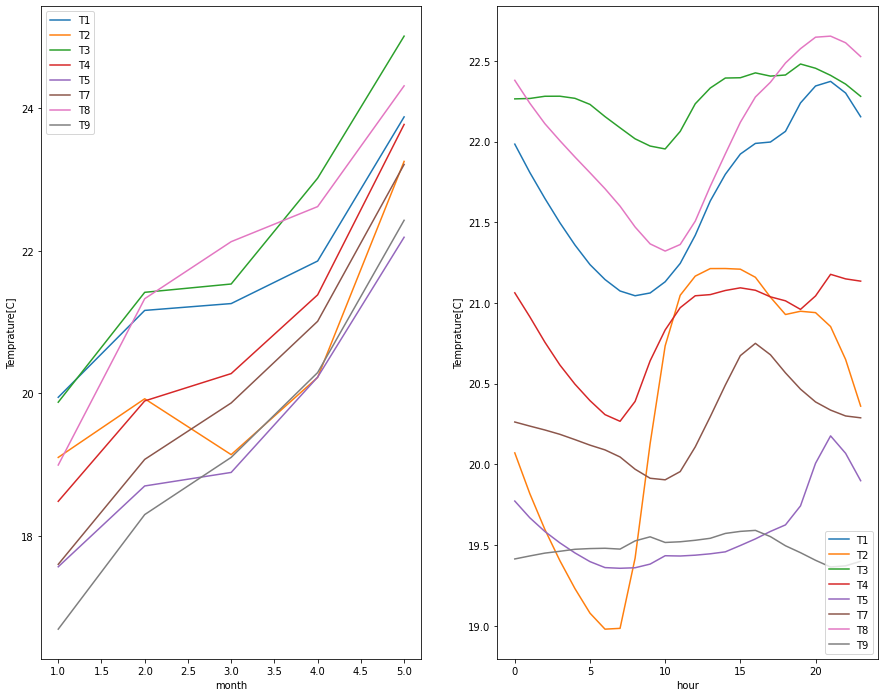

In [101]:
ccgroup1_gb_month = gb_month[correlated_column_group_1]
ccgroup1_gb_hour = gb_hour[correlated_column_group_1]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=FIGURE_SIZE)
ccgroup1_gb_month.mean().plot(ax=ax1)
ccgroup1_gb_hour.mean().plot(ax=ax2)

ax1.set_ylabel('Temprature[C]')
ax2.set_ylabel('Temprature[C]')

From this view, we can see the besides T2, most of those features shows a very similar trend and a small variety of values (around 1 degree), but T2 shows a different trend from the rest, and offers a wider variety of values(up to 3 degrees)

we'll first create a function to average the correlated features and then we'll add the irrelevant results to our irrelevant features list

In [17]:
def features_average (df, features_to_average, new_feature_name):
    df[new_feature_name] = np.mean(df[features_to_average], axis=1)
    return df

In [18]:
correlated_column_group_1.remove('T2')
irrelevant_features = irrelevant_features + correlated_column_group_1
features_df = features_average(features_df,
                               features_to_average = correlated_column_group_1,
                               new_feature_name = 'T_avg_1_3_4_5_7_8_9')
features_df.sample(5)

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,dayofweek,month,hour,weekday,T_avg_1_3_4_5_7_8_9
13175,2016-04-12 04:50:00,21.79,42.700000,19.200000,44.730000,23.426667,40.530000,21.790000,39.590000,20.79,44.225714,6.060000,56.193333,21.500000,35.730000,22.50,43.168571,20.823333,44.700000,6.283333,751.566667,90.500000,1.166667,40.000000,4.900000,1,4,4,0,21.802857
91,2016-01-12 08:10:00,19.79,48.533333,19.066667,45.060000,20.133333,45.290000,19.200000,45.760000,18.10,52.126667,5.090000,96.026667,17.856667,44.660000,18.79,51.633333,17.100000,48.360000,5.050000,741.883333,91.000000,5.000000,40.000000,3.733333,1,1,8,0,18.710000
15736,2016-04-29 23:40:00,22.79,36.590000,20.200000,38.966667,22.666667,36.363333,19.790000,38.290000,19.20,43.400000,7.090000,51.463333,19.200000,34.200000,21.79,46.526667,18.926667,39.363333,6.966667,756.366667,94.333333,2.333333,28.666667,6.133333,4,4,23,0,20.623333
16772,2016-05-07 04:20:00,23.79,37.730000,21.633333,39.066667,24.500000,38.126667,23.600000,36.663333,21.10,48.126667,10.625714,23.440000,22.790000,34.090000,23.70,43.200000,21.790000,43.290000,12.033333,752.033333,64.666667,1.000000,40.000000,5.466667,5,5,4,1,23.038571
18113,2016-05-16 11:50:00,22.79,39.433333,21.700000,39.620000,24.600000,37.337143,23.356667,37.223333,22.60,41.125714,15.823333,9.233333,23.100000,32.433333,24.39,37.920000,22.823333,39.330000,9.183333,761.400000,72.000000,1.000000,29.166667,4.300000,0,5,11,0,23.380000


### correlated column group 2

Text(0, 0.5, 'Humidity[%]')

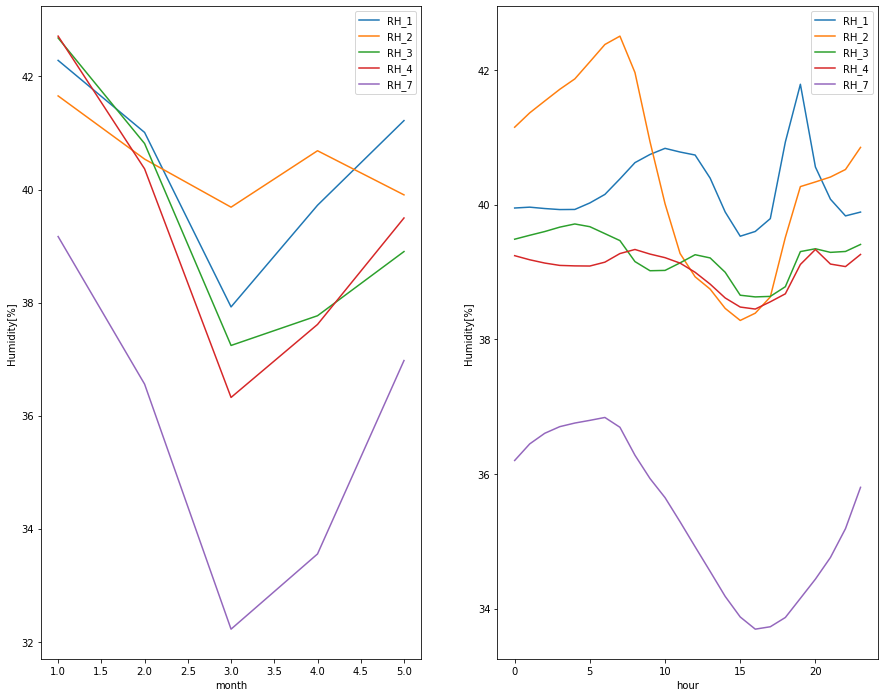

In [102]:
ccgroup2_gb_month = gb_month[correlated_column_group_2]
ccgroup2_gb_hour = gb_hour[correlated_column_group_2]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=FIGURE_SIZE)
ccgroup2_gb_month.mean().plot(ax=ax1)
ccgroup2_gb_hour.mean().plot(ax=ax2)

ax1.set_ylabel('Humidity[%]')
ax2.set_ylabel('Humidity[%]')

Again, we can see that we have a group of features that acts similarly and one "outlair" ('RH_7')

We'll deal with it in the same manner

In [20]:
correlated_column_group_2.remove('RH_7')
irrelevant_features = irrelevant_features + correlated_column_group_2
features_df = features_average(features_df,
                               features_to_average = correlated_column_group_2,
                               new_feature_name = 'RH_avg_1_2_3_4')
features_df.sample(5)

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,dayofweek,month,hour,weekday,T_avg_1_3_4_5_7_8_9,RH_avg_1_2_3_4
1579,2016-01-22 16:10:00,18.29,39.163333,17.133333,39.500,18.29,39.450000,16.066667,38.966667,16.10,47.790000,4.123333,97.456667,16.200000,33.927778,17.683333,41.972222,15.690000,39.260000,3.000000,760.550000,88.833333,5.166667,59.166667,1.333333,4,1,16,0,16.902857,39.270000
14580,2016-04-21 23:00:00,22.79,37.030000,21.323333,37.260,23.20,36.863333,22.850000,34.754000,20.60,42.700000,13.963333,5.933333,22.100000,35.264286,22.790000,42.956667,20.200000,38.090000,13.600000,760.200000,61.000000,3.000000,40.000000,6.200000,3,4,23,0,22.075714,36.476833
253,2016-01-13 11:10:00,19.23,45.030000,18.700000,43.145,19.39,43.500000,19.790000,41.826667,17.76,53.760000,5.933333,76.000000,17.500000,40.126667,18.000000,47.700000,17.000000,45.656667,5.583333,756.783333,80.166667,5.166667,30.833333,2.350000,2,1,11,0,18.381429,43.375417
18214,2016-05-17 04:40:00,22.70,39.590000,20.390000,41.290,24.52,38.090000,22.700000,37.790000,19.85,42.356000,7.800000,42.300000,23.528571,36.500000,23.875714,40.412857,22.700000,41.290000,8.933333,759.333333,93.000000,2.000000,56.333333,7.866667,1,5,4,0,22.839184,39.190000
7964,2016-03-07 00:20:00,19.89,37.700000,17.600000,39.700,20.10,39.126667,20.263333,37.566667,17.79,66.893333,-0.900000,77.400000,17.890000,31.760000,21.500000,42.626667,17.566667,37.326667,0.000000,747.700000,98.000000,1.000000,48.000000,-0.300000,0,3,0,0,19.285714,38.523333


### correlated column group 3

Text(0, 0.5, 'Temprature[C]')

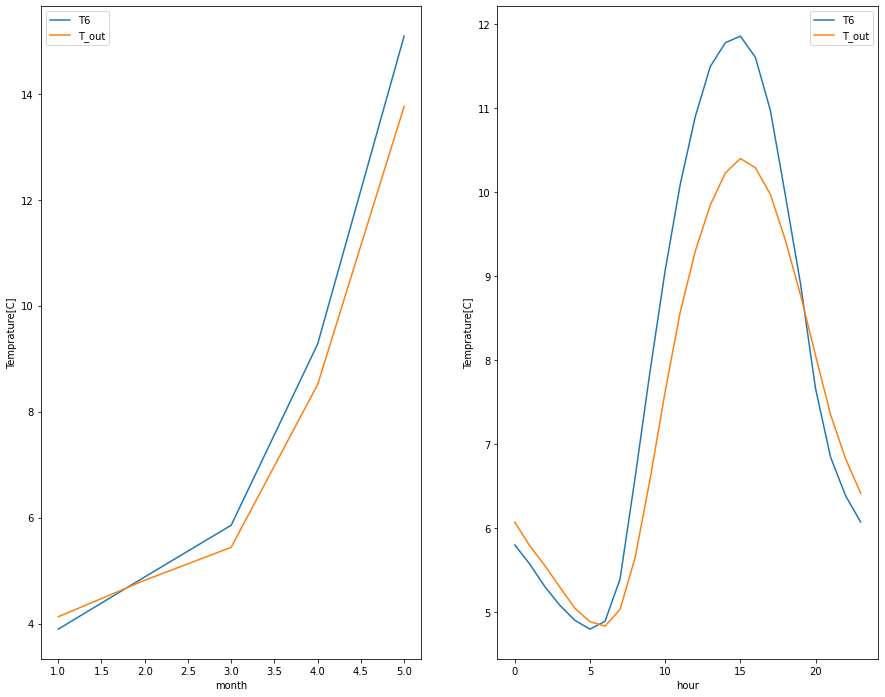

In [96]:
ccgroup3_gb_month = gb_month[correlated_column_group_3]
ccgroup3_gb_hour = gb_hour[correlated_column_group_3]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=FIGURE_SIZE)
ccgroup3_gb_month.mean().plot(ax=ax1)
ccgroup3_gb_hour.mean().plot(ax=ax2)

ax1.set_ylabel('Temprature[C]')
ax2.set_ylabel('Temprature[C]')

These two features are almost identical - so we'll unite them

In [22]:
irrelevant_features = irrelevant_features + correlated_column_group_3
features_df = features_average(features_df,
                               features_to_average = correlated_column_group_3,
                               new_feature_name = 'T_avg_6_out')
features_df.sample(5)

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,dayofweek,month,hour,weekday,T_avg_1_3_4_5_7_8_9,RH_avg_1_2_3_4,T_avg_6_out
1133,2016-01-19 13:50:00,19.00,39.90,17.790000,40.466667,19.00,39.790000,18.100000,37.290000,16.516667,55.740000,-0.900000,92.547222,18.116667,32.169444,19.301111,40.591111,16.89,38.090000,-0.166667,757.350000,67.333333,1.0,22.0,-5.583333,1,1,13,0,18.132063,39.361667,-0.533333
18405,2016-05-18 12:30:00,23.20,42.09,23.700000,39.230000,24.10,39.730000,23.390000,40.363333,21.160000,44.900000,20.596667,1.000000,22.790000,37.500000,23.033333,41.933333,22.60,40.236000,16.200000,751.000000,63.000000,6.5,29.0,9.050000,2,5,12,0,22.896190,40.353333,18.398333
15217,2016-04-26 09:10:00,20.79,37.09,21.323333,35.963333,21.89,35.090000,20.790000,35.000000,19.390000,45.760000,6.366667,58.333333,20.200000,30.390000,22.000000,39.000000,19.70,35.933333,4.250000,747.916667,77.500000,7.0,40.0,0.566667,1,4,9,0,20.680000,35.785833,5.308333
8987,2016-03-14 02:50:00,20.70,35.40,17.390000,39.433333,20.39,36.966667,19.633333,34.126667,18.500000,50.530000,0.372222,66.322778,21.500000,34.200000,22.981667,41.090000,19.29,39.200000,1.133333,768.716667,88.833333,3.0,63.0,-0.583333,0,3,2,0,20.427857,36.481667,0.752778
3373,2016-02-04 03:10:00,21.50,42.50,20.700000,41.900000,22.50,43.790000,20.290000,41.900000,18.975556,58.208889,1.200000,89.293333,18.583333,38.126667,22.100000,48.670000,18.39,48.000000,1.950000,765.866667,89.000000,3.0,24.0,0.350000,3,2,3,0,20.334127,42.522500,1.575000


### correlated column group 4

Text(0, 0.5, 'Humidity[%]')

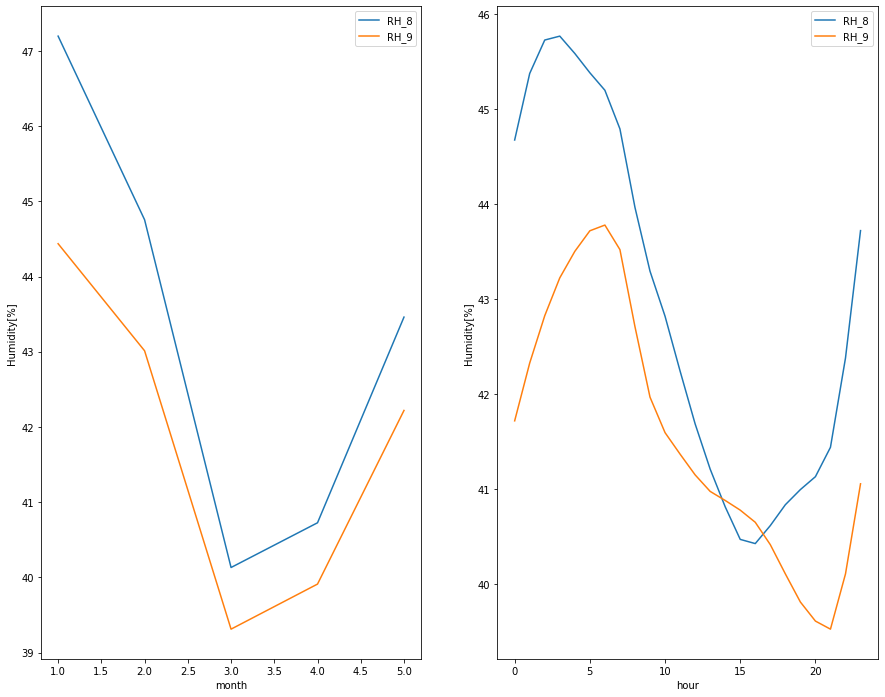

In [94]:
ccgroup4_gb_month = gb_month[correlated_column_group_4]
ccgroup4_gb_hour = gb_hour[correlated_column_group_4]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=FIGURE_SIZE)
ccgroup4_gb_month.mean().plot(ax=ax1)
ccgroup4_gb_hour.mean().plot(ax=ax2)

ax1.set_ylabel('Humidity[%]')
ax2.set_ylabel('Humidity[%]')

These two features are almost identical - so we'll unite them

In [24]:
irrelevant_features = irrelevant_features + correlated_column_group_4
features_df = features_average(features_df,
                               features_to_average = correlated_column_group_4,
                               new_feature_name = 'RH_avg_8_9')
features_df.sample(5)

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,dayofweek,month,hour,weekday,T_avg_1_3_4_5_7_8_9,RH_avg_1_2_3_4,T_avg_6_out,RH_avg_8_9
433,2016-01-14 17:10:00,21.633333,45.196667,20.926667,38.596667,21.960000,44.566667,18.633333,43.300000,17.10,53.000000,4.833333,75.233333,17.666667,38.663333,18.200000,45.590000,17.00,43.326667,4.583333,747.933333,76.000000,6.833333,40.000000,0.683333,3,1,17,0,18.884762,42.915000,4.708333,44.458333
11991,2016-04-03 23:30:00,22.100000,44.590000,20.890000,45.060000,22.890000,41.826667,21.200000,44.163333,19.79,49.730000,14.890000,38.466667,21.200000,40.363333,24.390000,49.093333,20.29,46.090000,15.250000,748.800000,75.500000,4.000000,40.000000,10.850000,6,4,23,1,21.694286,43.910000,15.070000,47.591667
6804,2016-02-27 23:00:00,21.500000,34.863333,20.000000,35.060000,20.823333,35.590000,19.390000,32.626667,17.89,53.538571,1.166667,50.366667,19.700000,30.140000,22.290000,37.566667,18.00,38.060000,1.700000,753.600000,69.000000,5.000000,25.000000,-3.400000,5,2,23,1,19.941905,34.535000,1.433333,37.813333
1214,2016-01-20 03:20:00,19.100000,39.200000,17.790000,39.200000,18.890000,39.126667,17.730000,38.290000,17.10,48.790000,-5.850000,82.408889,17.200000,32.790000,19.600000,45.700000,16.39,41.433333,-4.955556,758.855556,91.666667,1.222222,58.333333,-6.088889,2,1,3,0,18.001429,38.954167,-5.402778,43.566667
6620,2016-02-26 16:20:00,20.700000,35.863333,19.200000,35.760000,20.890000,36.030000,19.700000,33.933333,18.10,43.590000,7.800000,36.730000,18.700000,28.370000,19.633333,35.433333,18.00,37.126667,5.500000,752.166667,56.666667,2.333333,34.000000,-2.600000,4,2,16,0,19.389048,35.396667,6.650000,36.280000


### Summary and final exclusion

Now that we've found our irrelevant features, we'll exclude them from df and check again how many features we have now

In [25]:
irrelevant_features.append('hour')

chosen_features_df = features_df.drop(irrelevant_features, axis=1)
chosen_features_df.shape

(19735, 15)

So we're down to 15 features! much better! 

Lets take another look at the correlation map to see whats the current situation

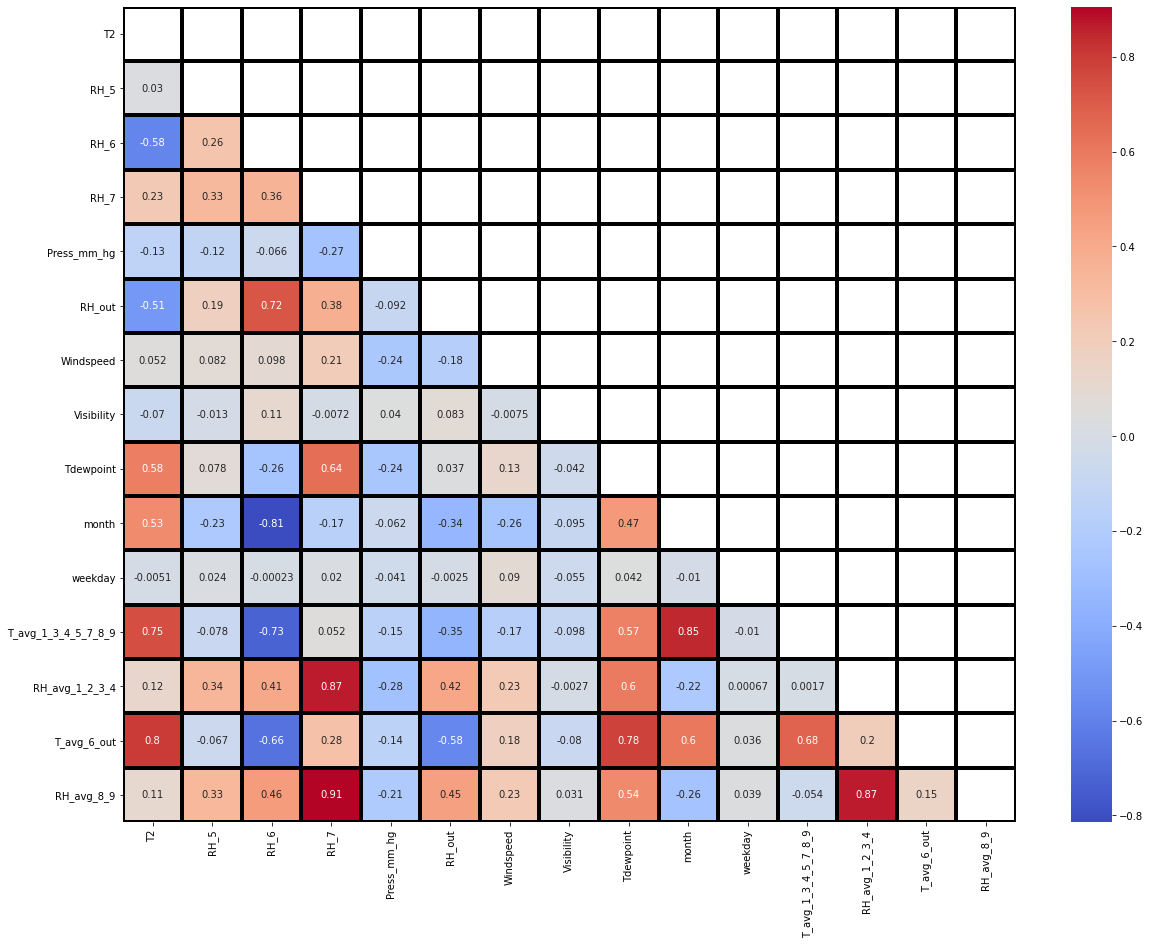

In [26]:
fig, ax = plt.subplots(figsize=SNS_FIGURE_SIZE)
mask_matrix = np.triu(chosen_features_df.corr())
sns.heatmap(chosen_features_df.corr(), annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', mask=mask_matrix)

## Preprocessing

Before we'll fit our selected features to the model, we'll preprocess(mostly normalization) our data.

Lets first divide the features into categories, so we can select different preprocessing for each group


In [27]:
temperature_columns = [column_name for column_name in chosen_features_df.columns if column_name.startswith('T')]
humidity_columns = [column_name for column_name in chosen_features_df.columns if column_name.startswith('RH')]
environment_columns = ['Windspeed', 'Press_mm_hg', 'Visibility']

For the temprature and humidity columns, we'll use a global min/max scaler. meaning that we'll take the global min/max from all temperature/humidity columns, and use those limits for our scaling the data between 0 to 1

To that purpose we'll bulit a custom transformer.

In [28]:
class CustomMinMaxScaler (BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_scale):
        self.columns_to_scale = columns_to_scale

    def fit(self, X, y=None):
        self.min_value_ = self._get_global_min(X[self.columns_to_scale])
        self.max_value_ = self._get_global_max(X[self.columns_to_scale])
        return self

    def transform(self, X, *_):
        norm_value = self.max_value_ - self.min_value_ 
        X[self.columns_to_scale] = X[self.columns_to_scale].apply(lambda x: (x-self.min_value_)/norm_value)
        return X

    def _get_global_max(self, part_X):
        return max(np.max(part_X))

    def _get_global_min(self, part_X):
        return min(np.min(part_X))

Lets test them out

In [29]:
scaled_features_df = chosen_features_df.copy()

temperature_scaler = CustomMinMaxScaler(columns_to_scale = temperature_columns)
temperature_scaler.fit_transform(scaled_features_df)

humidity_scaler = CustomMinMaxScaler(columns_to_scale = humidity_columns)
humidity_scaler.fit_transform(scaled_features_df)

,T2,RH_5,RH_6,RH_7,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,month,weekday,T_avg_1_3_4_5_7_8_9,RH_avg_1_2_3_4,T_avg_6_out,RH_avg_8_9
0,0.707689,0.547475,0.840976,0.410370,733.5,0.919192,7.000000,63.000000,0.326415,1,0,0.683708,0.451221,0.367925,0.466818
1,0.707689,0.547475,0.839024,0.409697,733.6,0.919192,6.666667,59.166667,0.323672,1,0,0.683839,0.449996,0.363674,0.466785
2,0.707689,0.546364,0.829865,0.408418,733.7,0.919192,6.333333,55.333333,0.320929,1,0,0.683290,0.448864,0.358325,0.465808
3,0.707689,0.546364,0.832559,0.406970,733.8,0.919192,6.000000,51.500000,0.318186,1,0,0.682493,0.447929,0.354988,0.464596
4,0.707689,0.546364,0.847407,0.406364,733.9,0.919192,5.666667,47.666667,0.315443,1,0,0.682885,0.447963,0.352473,0.464596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,0.891195,0.519192,0.000000,0.439394,755.2,0.552189,3.333333,23.666667,0.546768,5,0,0.859207,0.432674,0.832907,0.479111
19731,0.887465,0.518451,0.000000,0.438528,755.2,0.555556,3.500000,24.500000,0.545854,5,0,0.859026,0.432811,0.822849,0.477677
19732,0.884024,0.517845,0.000000,0.438384,755.2,0.558923,3.666667,25.333333,0.544939,5,0,0.858632,0.436326,0.813203,0.477020
19733,0.878138,0.517172,0.000000,0.437330,755.2,0.562290,3.833333,26.166667,0.544025,5,0,0.857584,0.437136,0.795008,0.476446


Great! for the rest of the columns, we'll scale them in the same range of our other columns, so we'll use the standard MinMaxScaler

In [30]:
min_max_scaler = MinMaxScaler()
scaled_features_df['Press_mm_hg'] = min_max_scaler.fit_transform(np.array(chosen_features_df['Press_mm_hg']).reshape(-1,1))
scaled_features_df['Windspeed'] = min_max_scaler.fit_transform(np.array(chosen_features_df['Windspeed']).reshape(-1,1))
scaled_features_df['Visibility'] = min_max_scaler.fit_transform(np.array(chosen_features_df['Visibility']).reshape(-1,1)) 

Good, so now we have our features chosen and scaled, we'll set the final groups and create a column transformer to orginize the results neatly.

In [31]:
class ColumnsDevision(Enum):
    final_temperature_columns = [column_name for column_name in scaled_features_df.columns if column_name.startswith('T')]
    final_humidity_columns = [column_name for column_name in scaled_features_df.columns if column_name.startswith('RH')]
    final_environment_columns = ['Press_mm_hg', 'Windspeed', 'Visibility']

column_transformer = make_column_transformer(
                        (CustomMinMaxScaler(columns_to_scale = ColumnsDevision.final_temperature_columns.value), ColumnsDevision.final_temperature_columns.value),
                        (CustomMinMaxScaler(columns_to_scale = ColumnsDevision.final_temperature_columns.value), ColumnsDevision.final_humidity_columns.value),
                        (MinMaxScaler(), ColumnsDevision.final_environment_columns.value),
                        )

# Model selection and optimization

## Inital model selection

First, we'll split the data into train/test sets, by ratio of 4:1 accordingly, or 80%-20% split

In [32]:
regression_df = scaled_features_df.copy()
X_train, X_test, y_train, y_test = train_test_split(regression_df, target_column, test_size=TEST_SIZE, random_state=RANDOM_STATE) # stratify=y

For initial test, we'll take the 3 models that we've learned so far and run them on our dataset, in order to choose on which model to foucs our hyper-parameter tuning 

In [33]:
models = [
           ['Linear regression: ', LinearRegression()],
           ['Desicion tree regressor: ', DecisionTreeRegressor()],
           ['KNeighbors regressor: ',  KNeighborsRegressor()],
         ]

rmse_loss = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model_data["Name"] = name
    curr_model.fit(X_train, y_train)
    curr_model_data["Train_RMSE_Score"] = round(rmse_loss(y_train, curr_model.predict(X_train)),2)
    curr_model_data["Train_R^2_Score"] = round(r2_score(y_train, curr_model.predict(X_train)),2)
    curr_model_data["Test_RMSE_Score"] = round(rmse_loss(y_test,curr_model.predict(X_test)),2)
    curr_model_data["Test_R^2_Score"] = round(r2_score(y_test,curr_model.predict(X_test)),2)
    model_data.append(curr_model_data)

model_data

[{'Name': 'Linear regression: ',
  'Test_RMSE_Score': 97.24,
  'Test_R^2_Score': 0.09,
  'Train_RMSE_Score': 99.99,
  'Train_R^2_Score': 0.09},
 {'Name': 'Desicion tree regressor: ',
  'Test_RMSE_Score': 90.49,
  'Test_R^2_Score': 0.21,
  'Train_RMSE_Score': 0.0,
  'Train_R^2_Score': 1.0},
 {'Name': 'KNeighbors regressor: ',
  'Test_RMSE_Score': 73.82,
  'Test_R^2_Score': 0.48,
  'Train_RMSE_Score': 59.91,
  'Train_R^2_Score': 0.67}]

Lets analyze the results:
1. Linear regression - very poor results on both the train and test sets, makes sense since we have a few categorical veriables which tends to hinder this regression.
2. Desicion tree regressor = seems to casue over fitting on the train set(R^2=1), and a poor score on the test set as a result.
3. K nearest neighbors regressor - medium results on both the train/test sets, but since it's the best out of the three we'll focus on it.

We have our regressor, but the results are still far from being optimized, which means we should go back to feature enginnering in order to improve our results

In order to asses the value of RMSE, we can look at the mean value of the target column and it's distribution

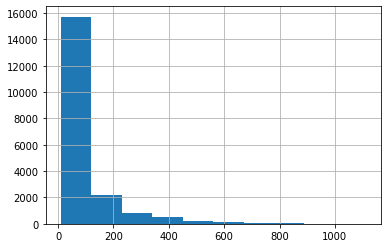

In [75]:
target_column.hist()

In [76]:
target_column.mean()

101.49683303775019

## Feature selection

Now that we've chosen a model, we'll need to optimize our feature selection.
We have 15 features - the number of possible combinations for feature selection is around 30k.. so in order to choose the right combination, we'll construct a series of functions designed to get all possible combinations (using itertools) and evaluate each one of them in our model.

The basic algorithim is as follows:
1. select a number of features (from 15 to 5)
2. find all possible combinations for that number of features
3. for each possible combination, run KNN regression
4. calculate the RMSE and R^2 for both train and test datasets
5. pick a different number of features and repeat steps 2-4 till all numbers between 5-15 were selected

We'll save the log and details in a dictionary call "models_data", and after we'll attempt to find the best 10 feature selections, by finding the minimum RMSE and the maximum R^2

After we'll have all that information, we can select a feature list for further optimization

**Note:** since we're doing a step-by-step optimization, we are at risk of missing the global optimal point and landing in local optimal point instead

In [77]:
class FeatureSelector ():
    def get_model_data (self, reg_model, X_train, X_test, y_train, y_test):
        model_data = {}
        model_data['features'] = set(X_train.columns)
        model_data['parameters'] = reg_model.get_params()
        reg_model.fit(X_train, y_train)
        y_hat_train = reg_model.predict(X_train)
        y_hat_test = reg_model.predict(X_test)
        model_data['Train_RMSE_score'] = round(rmse_loss(y_train, y_hat_train),2)
        model_data['Train_R^2_score'] = round(r2_score(y_train, y_hat_train),2)
        model_data['Test_RMSE_score'] = round(rmse_loss(y_test, y_hat_test),2)
        model_data['Test_R^2_score'] = round(r2_score(y_test, y_hat_test),2)
        return model_data

    def build_and_test_model (self, reg_model, df, target_column):
        X_train, X_test, y_train, y_test = train_test_split(df, target_column, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        return self.get_model_data (reg_model, X_train, X_test, y_train, y_test)

    def feature_iterator (self, df, target_column, reg_model, min_features_num, max_features_num):
        models_data = {}
        for features_num in range(min_features_num, max_features_num):
            possible_features = set(combinations(df.columns, features_num))
            for inner_index, selected_features in enumerate(possible_features):
                model_name = 'reg_model_' + str(features_num) + '_' + str(inner_index)
                models_data[model_name] = self.build_and_test_model (reg_model, df[list(selected_features)], target_column)
        return models_data

    def get_n_best_models(self, models_data, key_parameter, result_goal, n_results):
        best_models_names = []
        temp_models_data = models_data.copy()
        for index in range(n_results):
            if result_goal == 'max':
                current_best_model_name = self.get_model_max_value(temp_models_data, key_parameter)
            elif result_goal == 'min':
                current_best_model_name = self.get_model_min_value(temp_models_data, key_parameter)
            best_models_names.append(current_best_model_name)
            del temp_models_data[current_best_model_name]
        return best_models_names

    def get_model_max_value (self, models_data, key_parameter):
        max_value = 0
        for name, model in models_data.items():
            if model[key_parameter] > max_value:
                max_value = model[key_parameter]
                model_name = name
        return model_name

    def get_model_min_value (self, models_data, key_parameter):
        min_value = 1000000
        for name, model in models_data.items():
            if model[key_parameter] < min_value:
                min_value = model[key_parameter]
                model_name = name
        return model_name

    def models_data_to_df (self, models_data, models_list, selected_keys):
        temp_list = []    
        for model_name in models_list:
            temp_dict = {key: value for key, value in models_data[model_name].items() if key in selected_keys}
            temp_list.append(temp_dict)
        result_df = pd.DataFrame(temp_list, index=models_list)
        return result_df

    def set_parameters (self, reg_model, parameters_name, parameters_value):
        for index, parameter_name in enumerate(parameters_name):
            setattr(reg_model, parameter_name, parameters_value[index])
        return reg_model
    
    def tune_models_parameters (self, df, target_column, reg_model, models_data, models_list, parameters_to_tune):
        parameter_matrix = product(*parameters_to_tune.values())
        new_models_data = models_data.copy()
        for model_name in models_list:
            selected_features = models_data[model_name].get('features')
            for inner_index, parameters in enumerate(parameter_matrix):
                reg_model = self.set_parameters(reg_model, parameters_to_tune.keys() ,parameters)
                new_model_name = model_name + '_' + str(inner_index)
                new_models_data[new_model_name] = self.build_and_test_model (reg_model, df[list(selected_features)], target_column)
        return new_models_data

feature_selector = FeatureSelector()

In [35]:
# number of combination - 15 choose 5 + 15 choose 6 + 15 choose 7 + ..
models_data = feature_selector.feature_iterator(scaled_features_df, target_column, KNeighborsRegressor(), 5, len(scaled_features_df.columns))

In [36]:
models_data

{'reg_model_5_0': {'Test_RMSE_score': 79.66,
  'Test_R^2_score': 0.39,
  'Train_RMSE_score': 64.38,
  'Train_R^2_score': 0.62,
  'features': {'Press_mm_hg', 'RH_5', 'RH_6', 'Windspeed', 'weekday'},
  'parameters': {'algorithm': 'auto',
   'leaf_size': 30,
   'metric': 'minkowski',
   'metric_params': None,
   'n_jobs': None,
   'n_neighbors': 5,
   'p': 2,
   'weights': 'uniform'}},
 'reg_model_5_1': {'Test_RMSE_score': 72.37,
  'Test_R^2_score': 0.5,
  'Train_RMSE_score': 59.77,
  'Train_R^2_score': 0.68,
  'features': {'Press_mm_hg',
   'RH_avg_8_9',
   'RH_out',
   'T_avg_6_out',
   'Tdewpoint'},
  'parameters': {'algorithm': 'auto',
   'leaf_size': 30,
   'metric': 'minkowski',
   'metric_params': None,
   'n_jobs': None,
   'n_neighbors': 5,
   'p': 2,
   'weights': 'uniform'}},
 'reg_model_5_2': {'Test_RMSE_score': 80.96,
  'Test_R^2_score': 0.37,
  'Train_RMSE_score': 66.26,
  'Train_R^2_score': 0.6,
  'features': {'RH_avg_8_9', 'T2', 'Tdewpoint', 'Windspeed', 'weekday'},
  'par

Now that we have the results, we can find the optimal combinations for RMSE/R^2

In [66]:
selected_keys = ('Test_R^2_score', 'Test_RMSE_score', 'Train_R^2_score', 'Train_RMSE_score')
selected_models = feature_selector.get_n_best_models(models_data, 'Test_R^2_score', 'max', 10)
result_df = feature_selector.models_data_to_df(models_data, selected_models, selected_keys)
result_df

,Train_RMSE_score,Train_R^2_score,Test_RMSE_score,Test_R^2_score
reg_model_5_1394,57.02,0.70,68.83,0.55
reg_model_6_384,57.05,0.70,68.33,0.55
reg_model_6_2079,57.27,0.70,68.64,0.55
reg_model_6_2539,56.83,0.71,68.50,0.55
reg_model_6_3118,56.67,0.71,68.52,0.55
reg_model_6_3497,57.46,0.70,68.85,0.55
reg_model_6_3532,57.28,0.70,68.32,0.55
reg_model_7_392,56.60,0.71,68.81,0.55
reg_model_7_579,57.26,0.70,68.52,0.55
reg_model_7_1911,56.85,0.71,68.45,0.55


In [67]:
features_opt1_df = scaled_features_df[models_data[selected_models[0]].get('features')]

In [68]:
selected_keys = ('Test_R^2_score', 'Test_RMSE_score', 'Train_R^2_score', 'Train_RMSE_score')
selected_models = feature_selector.get_n_best_models(models_data, 'Test_RMSE_score', 'min', 10)
result_df = feature_selector.models_data_to_df(models_data, selected_models, selected_keys)
result_df

,Train_RMSE_score,Train_R^2_score,Test_RMSE_score,Test_R^2_score
reg_model_6_3532,57.28,0.70,68.32,0.55
reg_model_7_3741,56.95,0.71,68.32,0.55
reg_model_6_3532_3,57.28,0.70,68.32,0.55
reg_model_6_3532_13,57.28,0.70,68.32,0.55
reg_model_6_3532_23,57.28,0.70,68.32,0.55
reg_model_6_3532_33,57.28,0.70,68.32,0.55
reg_model_6_3532_43,57.28,0.70,68.32,0.55
reg_model_6_3532_53,57.28,0.70,68.32,0.55
reg_model_6_384,57.05,0.70,68.33,0.55
reg_model_6_3532_2,57.23,0.70,68.33,0.55


In [69]:
features_opt2_df = scaled_features_df[models_data[selected_models[0]].get('features')]

## Hyperparameter finetuning using GridSearchCV

### Setting up and running the search

Our first attempt to finetune the models parameter will be using GridSearchCV.
In order to do so, we'll need to carefully define parameter ranges and scoring methods

In [42]:
r2_scorer = make_scorer (r2_score)
rmse_scorer = make_scorer (rmse_loss)

leaf_size_range = [10, 20, 30, 40, 50, 60]
n_neighbors_range = [3, 5, 7, 9, 11]
p_range = [1, 2]
        
tuned_params = {
    'leaf_size': leaf_size_range,
    'n_neighbors': n_neighbors_range,
    'p' : p_range
               }

scoring = {'RMSE' : rmse_scorer,
           'R^2' : r2_scorer}

Now that everything is set, we can define the grid search object and use it to optimize our model

In [43]:
gs = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = tuned_params, scoring= scoring, refit='RMSE', cv=5, return_train_score=True)

gs.fit(features_opt1_df, target_column)
features_opt1_best_params = gs.best_params_

gs.fit(features_opt2_df, target_column)
features_opt2_best_params = gs.best_params_

### the results and final selection

In [70]:
features_opt1_best_params

{'leaf_size': 10, 'n_neighbors': 3, 'p': 2}

In [71]:
features_opt2_best_params

{'leaf_size': 10, 'n_neighbors': 3, 'p': 2}

In [46]:
cv_results_df = pd.concat([pd.DataFrame(gs.cv_results_['params']),
                           pd.DataFrame(gs.cv_results_['mean_test_RMSE'], columns=['RMSE']),
                           pd.DataFrame(gs.cv_results_['mean_test_R^2'], columns=['R^2'])] ,axis=1)
cv_results_df = cv_results_df.sort_values(['RMSE'], axis=0, ascending=False)
cv_results_df.head(10)

,leaf_size,n_neighbors,p,RMSE,R^2
11,20,3,2,135.681177,-0.728663
51,60,3,2,135.681177,-0.728663
41,50,3,2,135.681177,-0.728663
31,40,3,2,135.681177,-0.728663
1,10,3,2,135.681177,-0.728663
21,30,3,2,135.681177,-0.728663
0,10,3,1,135.615109,-0.733622
50,60,3,1,135.615109,-0.733622
40,50,3,1,135.615109,-0.733622
20,30,3,1,135.615109,-0.733622


To see the actual results of each model, we'll now run each model-df couple with its parameters

In [73]:
opt_clf_1 = KNeighborsRegressor()
for parameter, value in features_opt1_best_params.items():
    setattr(opt_clf_1, parameter, value)
feature_selector.build_and_test_model(opt_clf_1, features_opt1_df, target_column)

{'Test_RMSE_score': 63.01,
 'Test_R^2_score': 0.62,
 'Train_RMSE_score': 43.19,
 'Train_R^2_score': 0.83,
 'features': {'Press_mm_hg',
  'RH_avg_1_2_3_4',
  'T2',
  'T_avg_6_out',
  'Tdewpoint'},
 'parameters': {'algorithm': 'auto',
  'leaf_size': 10,
  'metric': 'minkowski',
  'metric_params': None,
  'n_jobs': None,
  'n_neighbors': 3,
  'p': 2,
  'weights': 'uniform'}}

In [74]:
opt_clf_2 = KNeighborsRegressor()
for parameter, value in features_opt2_best_params.items():
    setattr(opt_clf_2, parameter, value)
feature_selector.build_and_test_model(opt_clf_2, features_opt2_df, target_column)

{'Test_RMSE_score': 61.92,
 'Test_R^2_score': 0.63,
 'Train_RMSE_score': 42.98,
 'Train_R^2_score': 0.83,
 'features': {'Press_mm_hg',
  'RH_avg_8_9',
  'T2',
  'T_avg_1_3_4_5_7_8_9',
  'T_avg_6_out',
  'Tdewpoint'},
 'parameters': {'algorithm': 'auto',
  'leaf_size': 10,
  'metric': 'minkowski',
  'metric_params': None,
  'n_jobs': None,
  'n_neighbors': 3,
  'p': 2,
  'weights': 'uniform'}}

## Hyperparameter finetuning using FeatureSelector (custom)

Alternatively, we can use the FeatureSelector we've built here

In order to expend out search and lower the chance that we've landed on a local optimum point, we'll now search the "top" models with different features, and for each of these models tune the parameters for optimum results

To that purpose, we'll use our FeatureSelector

### Setting up and running the search

In [82]:
selected_models = feature_selector.get_n_best_models(models_data, 'Test_RMSE_score', 'min', 10) + feature_selector.get_n_best_models(models_data, 'Test_R^2_score', 'max', 10)

In [83]:
updated_models_data = feature_selector.tune_models_parameters (scaled_features_df, target_column, KNeighborsRegressor(), models_data, selected_models, tuned_params)

### the results and final selection

In [84]:
selected_keys = ('Test_R^2_score', 'Test_RMSE_score', 'Train_R^2_score', 'Train_RMSE_score')
selected_models = feature_selector.get_n_best_models(updated_models_data, 'Test_RMSE_score', 'min', 10) + feature_selector.get_n_best_models(updated_models_data, 'Test_R^2_score', 'max', 10)
result_df = feature_selector.models_data_to_df(updated_models_data, selected_models, selected_keys)
result_df

,Train_RMSE_score,Train_R^2_score,Test_RMSE_score,Test_R^2_score
reg_model_6_3532_0,42.53,0.84,61.79,0.63
reg_model_6_3532_10,42.53,0.84,61.79,0.63
reg_model_6_3532_20,42.53,0.84,61.79,0.63
reg_model_6_3532_30,42.53,0.84,61.79,0.63
reg_model_6_3532_40,42.53,0.84,61.79,0.63
reg_model_6_3532_50,42.53,0.84,61.79,0.63
reg_model_6_3532_1,42.98,0.83,61.92,0.63
reg_model_6_3532_11,42.98,0.83,61.92,0.63
reg_model_6_3532_21,42.98,0.83,61.92,0.63
reg_model_6_3532_31,42.98,0.83,61.92,0.63


In [85]:
features_opt3_df = scaled_features_df[updated_models_data[selected_models[0]].get('features')]
features_opt3_best_params = updated_models_data[selected_models[0]].get('parameters')
opt_clf_3 = KNeighborsRegressor()
for parameter, value in features_opt3_best_params.items():
    setattr(opt_clf_3, parameter, value)
feature_selector.build_and_test_model(opt_clf_3, features_opt2_df, target_column)

{'Test_RMSE_score': 61.79,
 'Test_R^2_score': 0.63,
 'Train_RMSE_score': 42.53,
 'Train_R^2_score': 0.84,
 'features': {'Press_mm_hg',
  'RH_avg_8_9',
  'T2',
  'T_avg_1_3_4_5_7_8_9',
  'T_avg_6_out',
  'Tdewpoint'},
 'parameters': {'algorithm': 'auto',
  'leaf_size': 10,
  'metric': 'minkowski',
  'metric_params': None,
  'n_jobs': None,
  'n_neighbors': 3,
  'p': 1,
  'weights': 'uniform'}}

# Final regressor (for production level)

In [88]:
class ClassiferContsants(Enum):   
    N_NEIGHBORS = 3
    LEAF_SIZE = 10
    P = 2

In [89]:
class KnnRegressor (BaseEstimator, ClassifierMixin):  
    def __init__(self,
                 n_neighbors = ClassiferContsants.N_NEIGHBORS.value,
                 leaf_size = ClassiferContsants.LEAF_SIZE.value,
                 p = ClassiferContsants.P.value,
                ):
      self.n_neighbors = n_neighbors
      self.leaf_size = leaf_size
      self.p = p

    def _pipeline_constructor(self):
        self.pipeline_ = Pipeline(steps=[
                                       ('classifier', KNeighborsRegressor(
                                                                          n_neighbors = self.n_neighbors,
                                                                          leaf_size = self.leaf_size,
                                                                          p = self.p,
                                                                                                 ),
                                       )])

    def fit(self, X, y=None):  
        self._pipeline_constructor()
        self.pipeline_.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.pipeline_.predict(X)

    def score(self, X, y=None):
        rmse_score = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
        rmse, r2 = round(rmse_score(X, y), 2), round(r2_score(X, y), 2)
        print(f"RMSE = {rmse}\t R^2 = {r2}")
        return rmse, r2

In [92]:
clf = KnnRegressor()
print('Model 1 results:')
regression_df = features_opt1_df.copy()
X_train, X_test, y_train, y_test = train_test_split(regression_df, target_column, test_size=TEST_SIZE, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
print ('Train results')
clf.score(y_train, clf.predict(X_train))
print ('Test_results')
clf.score(y_test, clf.predict(X_test))

print('\nModel 2 results:')
regression_df = features_opt2_df.copy()
X_train, X_test, y_train, y_test = train_test_split(regression_df, target_column, test_size=TEST_SIZE, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
print ('Train results')
clf.score(y_train, clf.predict(X_train))
print ('Test_results')
clf.score(y_test, clf.predict(X_test))

print('\nModel 3 results:')
regression_df = features_opt3_df.copy()
X_train, X_test, y_train, y_test = train_test_split(regression_df, target_column, test_size=TEST_SIZE, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
print ('Train results')
clf.score(y_train, clf.predict(X_train))
print ('Test_results')
clf.score(y_test, clf.predict(X_test))

Model 1 results:
Train results
RMSE = 43.19	 R^2 = 0.83
Test_results
RMSE = 63.01	 R^2 = 0.62

Model 2 results:
Train results
RMSE = 42.98	 R^2 = 0.83
Test_results
RMSE = 61.92	 R^2 = 0.63

Model 3 results:
Train results
RMSE = 42.98	 R^2 = 0.83
Test_results
RMSE = 61.92	 R^2 = 0.63


(61.92, 0.63)